In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

Previously I have performed data cleaning and missing value treatment on a complied dataset of customers' previous and current data, and saved that file. This is thevFeature Engineering and feature selection part of the said dataset.  You can look at the previous operations here: tinyurl.com/yn4zkz4u


In this script I will filter the data further, 
- and add some features that will enhance the quality of the data. 
- I will do outlier analysis on the data
- after that, I will rank the numeric features based on their importance
- after that I will segment the data based on numeric variables
  - to do that I will train the model without AMT_APPLICATION
  - then check whether the clusters show difference in distribution over AMT_APPLICATION
  - the clusters showed such a diiference.

## Reading and Segmenting the Data

In [3]:
df = pd.read_csv('cleanedloansdata_final.csv')

In [4]:
df.shape

(305545, 75)

In [5]:
df_1 = df.copy()

In [6]:
df.head()

,SK_ID_CURR,SK_ID_PREV,PREV_NAME_CONTRACT_TYPE,AMT_APPLICATION,PREV_AMT_CREDIT,PREV_WEEKDAY_APPR_PROCESS_START,PREV_HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CONTRACT_STATUS,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,2030495,Consumer loans,17145.0,17145.0,SATURDAY,15,1,1,Approved,...,0,0,0,0,0,0,0,0,0,0
1,100003,2802425,Cash loans,607500.0,679671.0,THURSDAY,11,1,1,Approved,...,0,0,0,0,0,0,0,0,0,0
2,100004,2523466,Cash loans,112500.0,136444.5,TUESDAY,11,1,1,Approved,...,0,0,0,0,0,0,0,0,0,0
3,100006,2819243,Cash loans,450000.0,470790.0,MONDAY,7,1,1,Approved,...,0,0,0,0,0,0,0,0,0,0
4,100007,1784265,Cash loans,337500.0,404055.0,THURSDAY,9,1,1,Refused,...,0,0,0,0,0,0,0,0,0,0


In [7]:
len(df.SK_ID_CURR.unique())

305545

In [8]:
def vardefiner(df):
    lst = df.columns
    l = []
    l_i = []
    l_f = []
    l_c = []
    l_b = []
    for var in lst:
        if (len(df[var].unique())<=2)&(df[var].dtype!='O'):
            l_b.append(var)
        elif df[var].dtype=='O':
            l_c.append(var)
        elif df[var].dtype=='float':
            l_f.append(var)
        else:
            l_i.append(var)
        
    l = [l_b,l_c,l_f,l_i]
    return(l)      # a function to classify the variables

In [9]:
varlist = vardefiner(df)
binary_vars = varlist[0]
cat_vars = varlist[1]
float_vars = varlist[2]
int_vars = varlist[3] # segmenting the variables

## Feature Engineering

In [10]:
documentlist = ['FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']   

In [11]:
df['TOTAL_DOCUMENTS'] = df[documentlist].sum(axis=1)

# coundting the total number of submitted document

In [12]:
for var in documentlist:
    df.drop(var, axis = 1,  inplace = True)
    
    # dropping the individual document variables

In [13]:
df['EXP_TERM'] = round(df['AMT_APPLICATION']/df['AMT_ANNUITY'],2) 

# roughly how long it would take to pay the loan

In [14]:
df['CREDIT_DIF'] = df['PREV_AMT_CREDIT'] - df['AMT_CREDIT'] 

# a negative value indicating customer has taken more credit

In [15]:
df['PERCENT_OF_VALUE'] = round(df['AMT_APPLICATION']/df['AMT_GOODS_PRICE']*100,2) 

# what percent of the price the person has taken credit for

In [16]:
df[df['PERCENT_OF_VALUE']>=100].AMT_GOODS_PRICE.describe() 

# these records are very problematic, let's look at their income
# it is not clear why they are applying for loans much more than the good's price
# there should be a flag for these records
# and see who these people are

count    4.101100e+04
mean     3.126600e+05
std      2.238094e+05
min      4.050000e+04
25%      1.575000e+05
50%      2.250000e+05
75%      4.500000e+05
max      2.250000e+06
Name: AMT_GOODS_PRICE, dtype: float64

In [17]:
df_e = df[df['PERCENT_OF_VALUE']>=100]








# XX | let's examine these records

In [18]:
df_e['ADJUSTED_INCOME'] = df_e['AMT_INCOME_TOTAL']/df['CNT_CHILDREN']


<AxesSubplot:xlabel='PERCENT_OF_VALUE', ylabel='ADJUSTED_INCOME'>

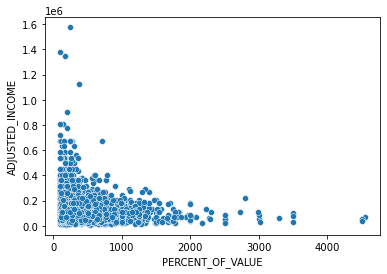

In [19]:
sns.scatterplot( data = df_e, x = 'PERCENT_OF_VALUE', y = 'ADJUSTED_INCOME')

# most of these really anomalous records came from low income groups
# how do they distribute if we leave out the students?

In [20]:
print('percent of non-students: {}'.format(df_e[df_e['NAME_INCOME_TYPE']!='Student'].shape[0]/df_e.shape[0]))
# so almost none of them are students


percent of non-students: 0.9999024651922654


In [21]:
# what is the percent of them that have been approved?

print('percent of approved loans: {}'.format(df_e[df_e['NAME_CONTRACT_STATUS']=='Approved'].shape[0]/df_e.shape[0]))


percent of approved loans: 0.6276852551754407


In [22]:
# how many are having difficulty paying back these loans?

df_target = df_e[df_e['NAME_CONTRACT_STATUS']=='Approved']
print('percent of people having difficulty paying these loans :{}'.format(df_target[df_target['TARGET']==1].shape[0]/df_target.shape[0]))

# because most of them are paying these loans without difficulty




# I think we don't need anymore flags for these records | XX

percent of people having difficulty paying these loans :0.08006370911351099


In [23]:
df['INCOME_F_ADJUSTED'] = round(df['AMT_INCOME_TOTAL']/(df['CNT_FAM_MEMBERS']+1),2)

# income/family members

In [24]:
df['INCOME_ADJUSTED'] = round(df['AMT_INCOME_TOTAL']/(df['CNT_CHILDREN']+1),2)

# income/no. of children

In [25]:
df.drop(['CNT_FAM_MEMBERS'], axis = 1, inplace = True)
df.drop(['CNT_CHILDREN'], axis = 1, inplace = True)

# dropping the variables

In [26]:
df['YEARS_EMPLOYED'] = round(df['DAYS_EMPLOYED']/365)
df.drop(['DAYS_EMPLOYED'], axis = 1, inplace = True)

# converting experience into years

In [27]:
df[df['YEARS_EMPLOYED']>=100].YEARS_EMPLOYED.describe() 

# these records are problematic

count    55026.0
mean      1001.0
std          0.0
min       1001.0
25%       1001.0
50%       1001.0
75%       1001.0
max       1001.0
Name: YEARS_EMPLOYED, dtype: float64

In [28]:
df[df['YEARS_EMPLOYED']<=100].YEARS_EMPLOYED.mean()*-1  

# this is the mean employed year without these records

6.534590190763974

In [29]:
def dayschecker(x):
    if x>0:
        return 6.5
    elif x == 0:
        return x*-1
    else:
        return round(x*-1,2) # writing a function to fix the problematic ones

In [30]:
df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].apply(dayschecker)

# applying the function

In [31]:
df['YEARS_EMPLOYED'].describe() # now we have a realistic distribution

count    305545.000000
mean          6.528361
std           5.806971
min           0.000000
25%           3.000000
50%           6.000000
75%           8.000000
max          49.000000
Name: YEARS_EMPLOYED, dtype: float64

In [32]:
df['REGION_RATING_CLIENT'].value_counts() # this is actually a categorical variable

# let's map this 

2    225559
3     48112
1     31874
Name: REGION_RATING_CLIENT, dtype: int64

In [33]:
def regionmap(x):
    if x==1:
        return 'pole1'
    elif x==2:
        return 'mid'
    else:
        return 'pole2'

In [34]:
df['REGION_RATING_CLIENT'] = df['REGION_RATING_CLIENT'].apply(regionmap)

In [35]:
df['REGION_RATING_CLIENT_W_CITY'] = df['REGION_RATING_CLIENT_W_CITY'].apply(regionmap)

In [36]:
df['AGE'] = round(df['DAYS_BIRTH']/365)*-1

df.drop(['DAYS_BIRTH'], axis = 1, inplace = True)

# converting age into years

In [37]:
df['AGE'].describe()

count    305545.000000
mean         43.943180
std          11.961179
min          21.000000
25%          34.000000
50%          43.000000
75%          54.000000
max          69.000000
Name: AGE, dtype: float64

In [38]:
def age(x):
    if x<=11:
        return 0
    elif (x>11) & (x<=24):
        return 1
    elif (x>=25)&(x<=33):
        return 2
    elif (x>=34)&(x<=45):
        return 3
    elif (x>=46)&(x<=54):
        return 4
    elif (x>=55)&(x<=75):
        return 5
    else:
        return 6  # dividing people into age groups

In [39]:
df['AGE_GRP'] = df['AGE'].apply(age)
df.drop(['AGE'], axis = 1, inplace = True)

In [40]:
varlist = vardefiner(df)
binary_vars = varlist[0]
cat_vars = varlist[1]
float_vars = varlist[2]
int_vars = varlist[3]    # reorganizing the lists

In [41]:
int_vars.remove('SK_ID_CURR')
int_vars.remove('SK_ID_PREV')

In [42]:
df['WEEKDAY_APPR_PROCESS_START'].value_counts() # this is an ordinal variables

TUESDAY      53588
WEDNESDAY    51596
MONDAY       50406
THURSDAY     50271
FRIDAY       49981
SATURDAY     33634
SUNDAY       16069
Name: WEEKDAY_APPR_PROCESS_START, dtype: int64

In [43]:
def week(x):
    if x == 'SUNDAY': 
        return 0
    elif x == 'MONDAY':
        return 1
    elif x == 'TUESDAY':
        return 2
    elif x == 'WEDNESDAY':
        return 3
    elif x == 'THURSDAY':
        return 4
    elif x == 'FRIDAY':
        return 5
    else:
        return 6 # so mapping these two variables

In [44]:
df['PREV_WEEKDAY_APPR_PROCESS_START'] = df['PREV_WEEKDAY_APPR_PROCESS_START'].apply(week)

In [45]:
df['WEEKDAY_APPR_PROCESS_START'] = df['WEEKDAY_APPR_PROCESS_START'].apply(week)

In [46]:
varlist = vardefiner(df)
binary_vars = varlist[0]
cat_vars = varlist[1]
float_vars = varlist[2]
int_vars = varlist[3]  # reorganizing the lists

In [47]:
df0 = df.copy()

In [48]:
df1 = df.copy  # for safety 


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Outlier Analysis

<AxesSubplot:xlabel='AMT_INCOME_TOTAL'>

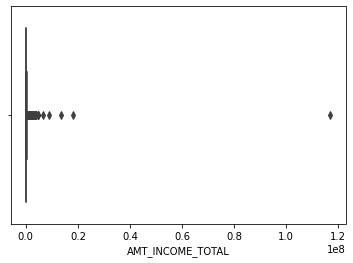

In [50]:
sns.boxplot(df.AMT_INCOME_TOTAL) # distribution of income levels

In [51]:
Q1 = df.AMT_INCOME_TOTAL.quantile(0.05)
Q3 = df.AMT_INCOME_TOTAL.quantile(0.95)
IQR = Q3 - Q1
df = df[(df.AMT_INCOME_TOTAL >= Q1 - 1.5*IQR) & (df.AMT_INCOME_TOTAL <= Q3 + 1.5*IQR)]


# I am using a realistic standard, so as not to lose a lot of datapoints

## Feature Selection

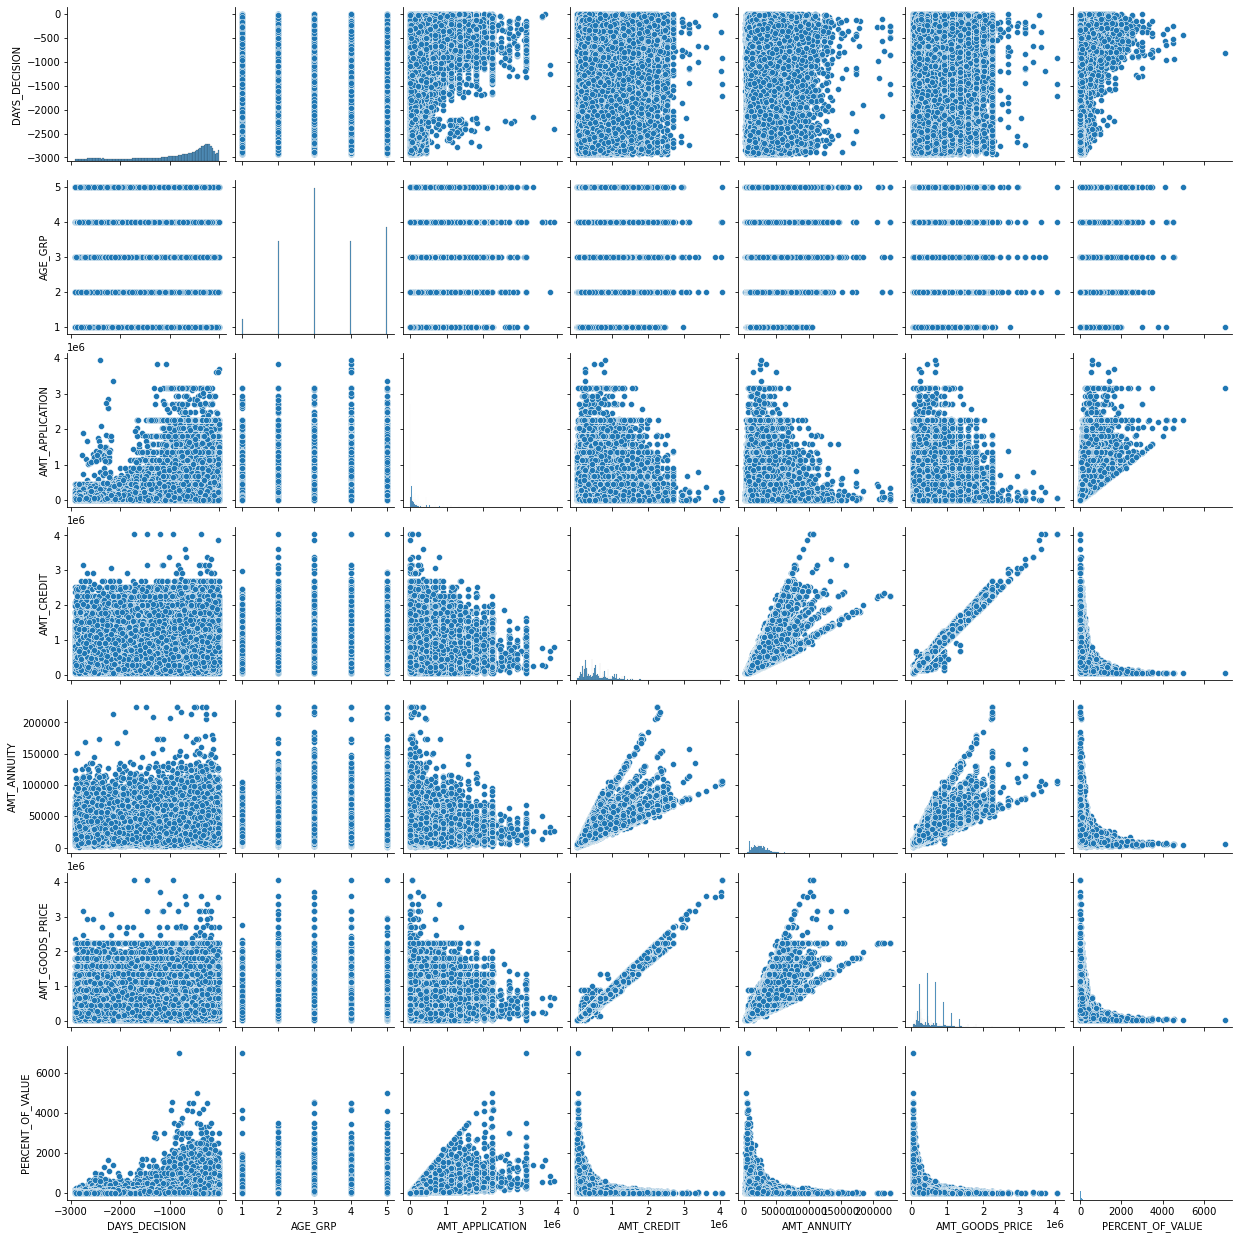

In [52]:
sns.pairplot(df[['DAYS_DECISION', 'AGE_GRP', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'PERCENT_OF_VALUE']])
plt.show()

# Credit and Aannuity are collinear
# Credit and Goods price are collinear, almost like a straight line
# Annuity and Goods price are collinear
# there are other less obvious relationships

In [53]:
df.shape

(304915, 59)

In [54]:
import sklearn
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

In [55]:
y = df.AMT_APPLICATION.values
df.drop(['AMT_APPLICATION'], axis = 1, inplace = True)
float_vars.remove('AMT_APPLICATION')
int_vars.remove('SK_ID_PREV') 
int_vars.remove('SK_ID_CURR')
X = df[int_vars + float_vars].to_numpy()
colnames = df[int_vars+float_vars].columns


In [56]:
# Define dictionary to store our rankings

ranks = {}

# Create our function which stores the feature rankings to the ranks dictionary

def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

1. RECURSIVE FEATURE ELIMINATION 

In [57]:
lr = LinearRegression(normalize=True)

lr.fit(X,y)

#stop the search when only the last feature is left

rfe = RFE(lr, n_features_to_select=1, verbose =3 )

rfe.fit(X,y)

ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


2. LINEAR MODEL FEATURE RANKING

In [58]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X,y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

3. RANDOM FOREST FRATURE RANKING

In [59]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=20, verbose=3)
rf.fit(X,y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 20building tree 2 of 20
building tree 3 of 20
building tree 4 of 20

building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   35.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   35.9s finished


### Feature Ranking Matrix

In [60]:
ranking_df = pd.DataFrame(ranks) # dataframe containing feature ranking

In [61]:
ranking_df

,RFE,LinReg,Ridge,Lasso,RF
PREV_WEEKDAY_APPR_PROCESS_START,0.61,0.0,0.01,0.01,0.00
PREV_HOUR_APPR_PROCESS_START,0.70,0.0,0.04,0.04,0.00
DAYS_DECISION,0.39,0.0,0.00,0.00,0.00
SELLERPLACE_AREA,0.17,0.0,0.00,0.00,0.00
DAYS_REGISTRATION,0.22,0.0,0.00,0.00,0.00
DAYS_ID_PUBLISH,0.26,0.0,0.00,0.00,0.00
WEEKDAY_APPR_PROCESS_START,0.30,0.0,0.00,0.00,0.00
HOUR_APPR_PROCESS_START,0.43,0.0,0.00,0.00,0.00
OBS_30_CNT_SOCIAL_CIRCLE,0.57,0.0,0.01,0.01,0.00
TOTAL_DOCUMENTS,0.87,0.0,0.26,0.24,0.00


In [62]:

r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
    methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

# comnputing the mean of the scores

In [63]:
colnames = df[int_vars+float_vars].columns

In [64]:
# Putting the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sorting the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

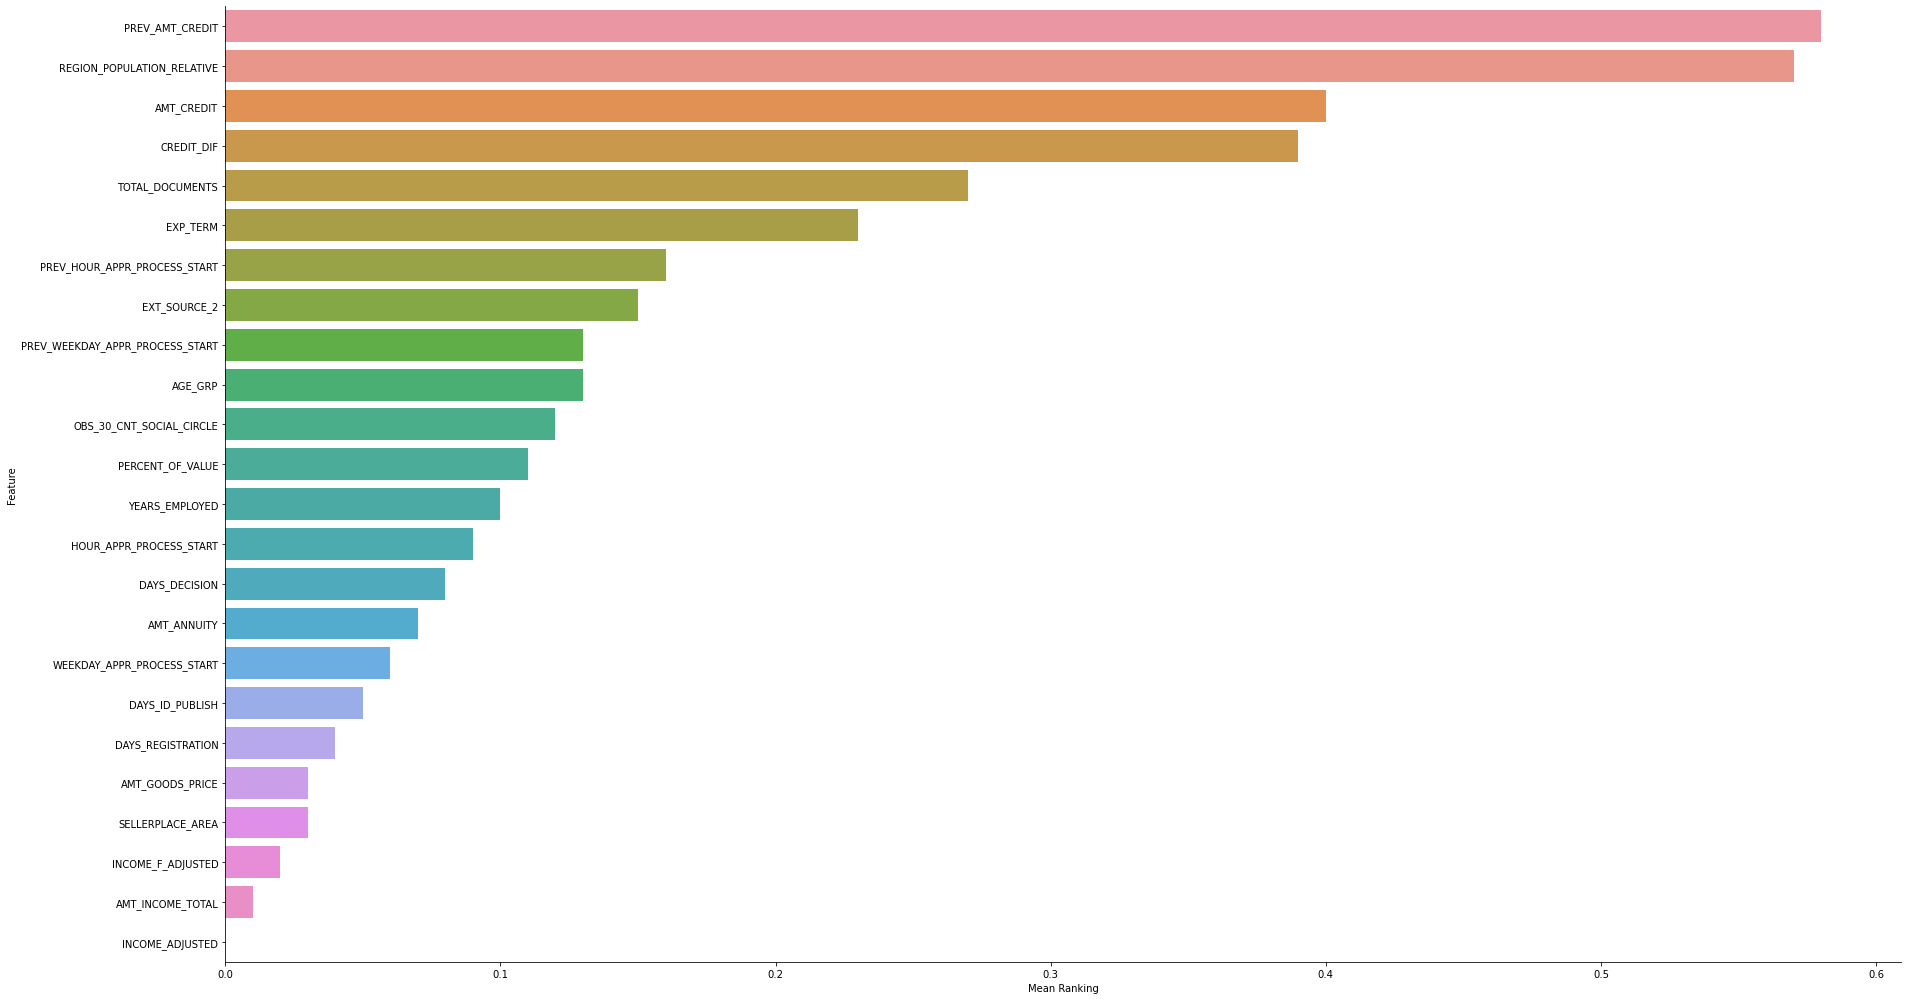

In [65]:
# Feature Ranking
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9)

In [66]:
ranks_df = pd.DataFrame(ranks)

In [67]:
ranks_df = ranks_df.sort_values(by = 'Mean', ascending = False)

In [68]:
ranks_df

,RFE,LinReg,Ridge,Lasso,RF,Mean
PREV_AMT_CREDIT,0.91,1.0,0.00,0.00,1.00,0.58
REGION_POPULATION_RELATIVE,0.83,0.0,1.00,1.00,0.00,0.57
AMT_CREDIT,1.00,1.0,0.00,0.00,0.00,0.40
CREDIT_DIF,0.96,1.0,0.00,0.00,0.00,0.39
TOTAL_DOCUMENTS,0.87,0.0,0.26,0.24,0.00,0.27
EXP_TERM,0.78,0.0,0.19,0.18,0.02,0.23
PREV_HOUR_APPR_PROCESS_START,0.70,0.0,0.04,0.04,0.00,0.16
EXT_SOURCE_2,0.74,0.0,0.00,0.00,0.00,0.15
PREV_WEEKDAY_APPR_PROCESS_START,0.61,0.0,0.01,0.01,0.00,0.13
AGE_GRP,0.65,0.0,0.00,0.00,0.00,0.13


In [69]:
ranks_df = ranks_df[ranks_df['Mean']>=0.1]

# setting an arbitrary cutoff

In [70]:
variables = ranks_df.T.columns

In [71]:
variables
variables = list(variables)

In [72]:
variables

['PREV_AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'AMT_CREDIT',
 'CREDIT_DIF',
 'TOTAL_DOCUMENTS',
 'EXP_TERM',
 'PREV_HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_2',
 'PREV_WEEKDAY_APPR_PROCESS_START',
 'AGE_GRP',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'PERCENT_OF_VALUE',
 'YEARS_EMPLOYED']

In [73]:
# I will drop the variables that will not be availabe for a prospective customer

variables.remove('AMT_CREDIT')
variables.remove('EXP_TERM')
variables.remove('PERCENT_OF_VALUE')
variables.remove('CREDIT_DIF')

In [115]:
variables.append('WEEKDAY_APPR_PROCESS_START')
variables.append('DAYS_REGISTRATION')
variables.append('DAYS_DECISION')

In [116]:
varlist = ['SK_ID_CURR']
for var in variables:
    varlist.append(var)

In [138]:
df_v = df[varlist]

## Pre-processing the Data

In [139]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_v_s = df[variables]

# fit_transform

df_v_scaled = scaler.fit_transform(df_v_s[variables])


In [140]:
df_v_scaled = pd.DataFrame(df_v_scaled)

In [141]:
df_v_scaled

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.557255,-0.146787,0.196163,0.752394,-1.313965,1.493845,-1.224437,0.239873,-0.779570,-0.090215,0.380133,1.043608
1,1.562501,-1.254894,0.196163,-0.448342,0.565992,0.452857,0.516756,-0.176424,-0.607348,-1.227397,1.079032,0.927706
2,-0.175556,-0.783549,-2.741465,-0.448342,0.218913,-0.588131,0.516756,-0.592721,-0.951793,-1.227397,0.206402,0.753217
3,0.894185,-0.929723,0.196163,-1.649077,0.713522,-1.108625,0.516756,0.239873,0.253766,-0.090215,-1.375631,0.484478
4,0.680666,0.569344,0.196163,-1.048709,-1.001127,0.452857,1.387352,-0.592721,0.253766,0.478376,0.191924,0.141868
...,...,...,...,...,...,...,...,...,...,...,...,...
304910,-0.612111,0.852398,0.196163,-0.448342,0.876722,-0.588131,-1.224437,-0.592721,-0.951793,0.478376,-0.984736,0.732839
304911,-0.074930,0.315264,0.196163,1.652945,-2.082889,-0.067637,1.387352,-0.592721,-0.004568,-1.227397,0.170066,-0.195648
304912,0.960702,-1.148803,0.196163,-0.148158,0.113271,-0.067637,-0.353840,1.905060,2.664884,0.478376,-0.496755,-0.674538
304913,-0.612111,-1.126220,0.196163,1.652945,0.000468,-0.588131,-1.224437,-0.592721,1.114879,-0.090215,0.688421,0.709913


In [142]:
df_v_scaled.columns = [variables]

## Modelling

In [143]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

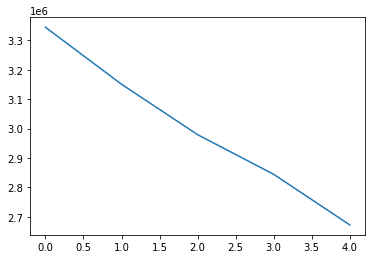

In [144]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_v_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plotting the SSDs for each n_clusters
# ssd
plt.plot(ssd)

# selecting n=3, because n=2 doesn't make much sense, and n=4 may be a little too much
# machine was incapable to compute the silhouette values

In [145]:
df_v

,SK_ID_CURR,PREV_AMT_CREDIT,REGION_POPULATION_RELATIVE,TOTAL_DOCUMENTS,PREV_HOUR_APPR_PROCESS_START,EXT_SOURCE_2,PREV_WEEKDAY_APPR_PROCESS_START,AGE_GRP,OBS_30_CNT_SOCIAL_CIRCLE,YEARS_EMPLOYED,WEEKDAY_APPR_PROCESS_START,DAYS_REGISTRATION,DAYS_DECISION
0,100002,17145.0,0.018801,1,15,0.262949,6,2,2,2.0,3,-3648,-73
1,100003,679671.0,0.003541,1,11,0.622246,4,4,1,3.0,1,-1186,-164
2,100004,136444.5,0.010032,0,11,0.555912,2,4,0,1.0,1,-4260,-301
3,100006,470790.0,0.008019,1,7,0.650442,1,4,2,8.0,3,-9833,-512
4,100007,404055.0,0.028663,1,9,0.322738,4,5,0,8.0,4,-4311,-781
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305540,456251,0.0,0.032561,1,11,0.681632,2,2,0,1.0,4,-8456,-317
305541,456252,167895.0,0.025164,1,18,0.115992,3,5,0,6.5,1,-4388,-1046
305542,456253,491580.0,0.005002,1,12,0.535722,3,3,6,22.0,4,-6737,-1422
305543,456254,0.0,0.005313,1,18,0.514163,2,2,0,13.0,3,-2562,-335


In [146]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(df_v_scaled) # training the model

KMeans(max_iter=50, n_clusters=3)

In [147]:
df_v['cluster_id'] = kmeans.labels_
df_v.head()

,SK_ID_CURR,PREV_AMT_CREDIT,REGION_POPULATION_RELATIVE,TOTAL_DOCUMENTS,PREV_HOUR_APPR_PROCESS_START,EXT_SOURCE_2,PREV_WEEKDAY_APPR_PROCESS_START,AGE_GRP,OBS_30_CNT_SOCIAL_CIRCLE,YEARS_EMPLOYED,WEEKDAY_APPR_PROCESS_START,DAYS_REGISTRATION,DAYS_DECISION,cluster_id
0,100002,17145.0,0.018801,1,15,0.262949,6,2,2,2.0,3,-3648,-73,1
1,100003,679671.0,0.003541,1,11,0.622246,4,4,1,3.0,1,-1186,-164,2
2,100004,136444.5,0.010032,0,11,0.555912,2,4,0,1.0,1,-4260,-301,1
3,100006,470790.0,0.008019,1,7,0.650442,1,4,2,8.0,3,-9833,-512,0
4,100007,404055.0,0.028663,1,9,0.322738,4,5,0,8.0,4,-4311,-781,0


In [148]:


# distribution of clusters of credit ammount

In [149]:
df_v1 = df_v.copy()

In [150]:
for var in variables:
    df_v.drop(var, axis = 1, inplace = True)

In [151]:
df

,SK_ID_CURR,SK_ID_PREV,PREV_NAME_CONTRACT_TYPE,PREV_AMT_CREDIT,PREV_WEEKDAY_APPR_PROCESS_START,PREV_HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CONTRACT_STATUS,DAYS_DECISION,...,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,TOTAL_DOCUMENTS,EXP_TERM,CREDIT_DIF,PERCENT_OF_VALUE,INCOME_F_ADJUSTED,INCOME_ADJUSTED,YEARS_EMPLOYED,AGE_GRP
0,100002,2030495,Consumer loans,17145.0,6,15,1,1,Approved,-73,...,0.262949,2,1,0.69,-389452.5,4.88,101250.0,202500.0,2.0,2
1,100003,2802425,Cash loans,679671.0,4,11,1,1,Approved,-164,...,0.622246,1,1,17.02,-613831.5,53.78,90000.0,270000.0,3.0,4
2,100004,2523466,Cash loans,136444.5,2,11,1,1,Approved,-301,...,0.555912,0,0,16.67,1444.5,83.33,33750.0,67500.0,1.0,4
3,100006,2819243,Cash loans,470790.0,1,7,1,1,Approved,-512,...,0.650442,2,1,15.16,158107.5,151.52,45000.0,135000.0,8.0,4
4,100007,1784265,Cash loans,404055.0,4,9,1,1,Refused,-781,...,0.322738,0,1,15.44,-108945.0,65.79,60750.0,121500.0,8.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305540,456251,2510843,Cash loans,0.0,2,11,1,1,Canceled,-317,...,0.681632,0,1,0.00,-254700.0,0.00,78750.0,157500.0,1.0,2
305541,456252,1386044,Cash loans,167895.0,3,18,1,1,Approved,-1046,...,0.115992,0,1,13.12,-101655.0,70.00,36000.0,72000.0,6.5,5
305542,456253,2116355,Cash loans,491580.0,3,12,1,1,Approved,-1422,...,0.535722,6,1,15.01,-186084.0,76.92,76500.0,153000.0,22.0,3
305543,456254,2430880,Cash loans,0.0,2,18,1,1,Canceled,-335,...,0.514163,0,1,0.00,-370107.0,0.00,57000.0,171000.0,13.0,2


In [152]:
frames = [df0, df_v]

In [153]:
df_x = pd.concat(frames, axis = 1, join = 'inner')

# joining the labels to the main dataset

<AxesSubplot:xlabel='cluster_id', ylabel='AMT_APPLICATION'>

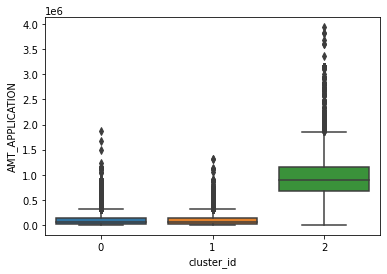

In [154]:
sns.boxplot(x='cluster_id', y='AMT_APPLICATION', data=df_x)

# distribution of the clusters over application ammounts

<AxesSubplot:xlabel='cluster_id', ylabel='CREDIT_DIF'>

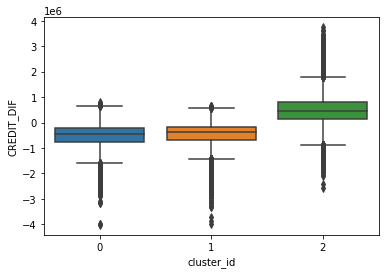

In [156]:
sns.boxplot(x='cluster_id', y='CREDIT_DIF', data=df_x)

# distribution of clusters over credit difference

<AxesSubplot:xlabel='cluster_id', ylabel='AMT_INCOME_TOTAL'>

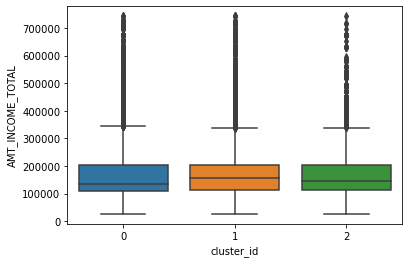

In [157]:
sns.boxplot(x='cluster_id', y='AMT_INCOME_TOTAL', data=df_x)

# distribution over the income groups

<AxesSubplot:xlabel='cluster_id', ylabel='AMT_CREDIT'>

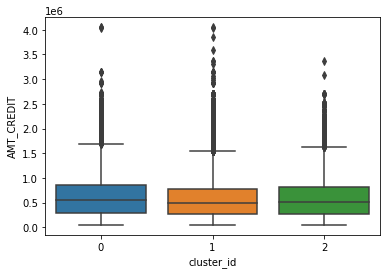

In [158]:
sns.boxplot(x='cluster_id', y='AMT_CREDIT', data=df_x)

- we see these segments perform differently over the different numeric variables
- so I consider this segmentation significant
- in the next script I will procedd to solve business problems with the data set

In [159]:
ranks_df.to_csv('variable_ranking.csv')
df_x.to_csv('feature_engineered_loansdata.csv')